# School Shooting EDA

In [435]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.dates as mdates
from scipy import stats
#plt.style.use('ggplot')

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet
#!pip install pystan==2.17.1.0 and fbprophet

In [3]:
school_df = pd.read_csv('data/school_shootings/cps_01_formatted.csv', sep = ',')
#gives census data based on type of school, N = Nursey, K = Kindergarten, E = Elementary, H = High school, C = College

In [4]:
school_df.head()

,Year,Total enrolled,N-Total,N-Public,N-Private,K-Total,K-Public,K-Private,E-Total,E-Public,E-Private,H-Total,H-Public,H-Private,C-Total,C-Public,C-Private,C-Full time
0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,76840.0,4836.0,2763.0,2073.0,3908.0,3529.0,379.0,32483.0,29665.0,2818.0,16706.0,15519.0,1187.0,18908.0,15234.0,3674.0,14204.0
3,2017,76409.0,4676.0,2782.0,1894.0,3964.0,3542.0,422.0,32530.0,29873.0,2656.0,16841.0,15546.0,1295.0,18398.0,14806.0,3592.0,13606.0
4,2016,77232.0,4746.0,2806.0,1941.0,4017.0,3654.0,364.0,32604.0,29978.0,2627.0,16668.0,15330.0,1338.0,19196.0,14971.0,4225.0,14421.0


In [5]:
shooting_df = pd.read_csv('data/school_shootings/pah_wikp_combo.csv', sep = ',')
#This dataset gives the date, location, areatype, school type, fatalities, wonded, description, etc. 
#for school shootings from 1991 to 2020. The Dupe column referes to if it was listed in both sources (duplicated).

#This is the main dataset I will be looking at.

In [6]:
shooting_df.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN


In [7]:
shooting_df.shape

(695, 10)

In [8]:
ownership = pd.read_csv('data/TL-354-State-Level Estimates of Household Firearm Ownership.csv', sep = ',')
# I ended up not using this dataset

In [9]:
ownership.head()

,FIP,Year,STATE,HFR,HFR_se,universl,permit,Fem_FS_S,Male_FS_S,BRFSS,GALLUP,GSS,PEW,HuntLic,GunsAmmo,BackChk,PewQChng,BS1,BS2,BS3
0,1,1980,Alabama,0.608,0.031,0,0,0.824324,0.833795,-9.0,0.55395,0.583632,-9.0,0.291102,-0.509164,-9.0,0,0.0,0.0,0.0
1,1,1981,Alabama,0.597,0.047,0,0,0.692308,0.831126,-9.0,-9.00000,-9.000000,-9.0,0.294962,-0.618954,-9.0,0,1.0,0.0,0.0
2,1,1982,Alabama,0.661,0.036,0,0,0.771739,0.821429,-9.0,-9.00000,0.655196,-9.0,0.290545,-0.526692,-9.0,0,2.0,0.0,0.0
3,1,1983,Alabama,0.586,0.038,0,0,0.688172,0.819277,-9.0,0.61144,-9.000000,-9.0,0.284983,-0.713227,-9.0,0,3.0,0.0,0.0
4,1,1984,Alabama,0.624,0.036,0,0,0.710000,0.775956,-9.0,-9.00000,0.626933,-9.0,0.281622,-0.733305,-9.0,0,4.0,0.0,0.0


In [10]:
ownership.shape

(1850, 20)

In [11]:
gun_laws = pd.read_csv('data/gun_laws/raw_data.csv')
#This dataset is from 1991 to 2017 and includes individual laws as well as total gun laws for each state. 
#It does not include Washington DC. The 'h' in some of the columns refers to handgun.

#This is the secondary dataset I'll use.

In [12]:
gun_laws.tail()

,state,year,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
1345,Virginia,2017,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
1346,Washington,2017,1,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,43
1347,West Virginia,2017,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,21
1348,Wisconsin,2017,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
1349,Wyoming,2017,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [13]:
#gun_laws.isnull().sum()

In [14]:
gun_laws.shape

(1350, 136)

In [15]:
gun_provisions = pd.read_excel('data/gun_laws/codebook.xlsx')
#An additional dataset about gun laws, but since it's not clear how it's referencing individual states 
#I don't think it will be useful.

In [16]:
gun_provisions.head()

,Category Code,Category,Sub-Category,Variable Name,Brief Description of Provision,Detailed Description of Provision,Coding Notes,Coding Instructions,Notes,Data Source and Attribution
0,1,Dealer regulations,Licensing,dealer,State dealer license required for sale of all ...,All firearm dealers are required to have a sta...,State requires all persons engaged in the busi...,If all firearm dealers are required to have a ...,NaN,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
1,1,Dealer regulations,Licensing,dealerh,State dealer license required for sale of hand...,All firearm dealers that sell handguns are req...,State requires all persons engaged in the busi...,If only dealers of handguns or handguns AND as...,NaN,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
2,1,Dealer regulations,Recordkeeping,recordsdealer,Licensed dealers are required to keep and reta...,Licensed dealers are required to keep and reta...,Recordkeeping refers to the recording of sales...,If record keeping and retention is required on...,Federal law requires licensed dealers to keep ...,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
3,1,Dealer regulations,Recordkeeping,recordsdealerh,Licensed dealers are required to keep and reta...,Licensed dealers are required to keep and reta...,Recordkeeping refers to the recording of sales...,If record keeping and retention is required on...,Federal law requires licensed dealers to keep ...,"Coded by Michael Siegel, MD, MPH, Boston Unive..."
4,1,Dealer regulations,Recordkeeping,recordsall,All private sellers and licensed dealers are r...,Both private sellers and licensed dealers are ...,Recordkeeping refers to the recording of sales...,If all private sellers and licensed dealers ar...,Federal law requires licensed dealers to keep ...,"Coded by Michael Siegel, MD, MPH, Boston Unive..."


In [17]:
state_guns = pd.read_csv(r'data/raw-thoughtco-guns-by-state.txt', delimiter = '\t')
#This dataset looks at gun ownership.
#Initally this was going to be my secondary dataset, but it made more sense to looks at gun laws. 
#Interesting to note the number of guns per capita in Wyoming is three times the second leading, Washington DC.

In [18]:
state_guns.head()

,Rank,State,# of guns per capita,# of guns registered
0,1,Wyoming,229.24,"132,806"
1,2,Washington D.C.,68.05,"47,228"
2,3,New Hampshire,46.76,"64,135"
3,4,New Mexico,46.73,"97,580"
4,5,Virginia,36.34,"307,822"


In [357]:
#state_guns.groupby('# of guns per capita').max()

In [19]:
state_guns.isnull().sum()

Rank                    0
State                   0
# of guns per capita    0
# of guns registered    0
dtype: int64

Inital EDA into the school shooting dataset.

In [20]:
shooting_df

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN
...,...,...,...,...,...,...,...,...,...,...
690,1/14/20,Bellaire,Texas,NaN,HS,1,0.0,NaN,Wikp,A 19-year old student was shot in the chest an...
691,1/14/20,Fort Worth,Texas,NaN,HS,0,2.0,NaN,Wikp,An adult male and a 10-year old child were inj...
692,1/23/20,Oxnard,California,NaN,ES,0,1.0,NaN,Wikp,NaN
693,2/3/20,Commerce,Texas,NaN,C,2,1.0,NaN,Wikp,"Jacques Dshawn Smith, 21, gained access to Pri..."


In [21]:
shooting_df.loc[shooting_df['Fatalities'] == max(shooting_df['Fatalities'])]
# df.loc[df['column_name'] == some_value]

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc
342,4/16/07,Blacksburg,Virginia,NaN,C,33,23.0,NaN,Wikp,"Virginia Tech shooting: 23-year-old student,¬†..."


In [22]:
shooting_df['Desc'][342]

'Virginia Tech shooting: 23-year-old student,¬†Seung-Hui Cho, killed thirty-two students and faculty members at¬†Virginia Tech, and wounded another seventeen students and faculty members in two separate attacks before committing suicide. The incident is the third-deadliest mass shooting by a single gunman in modern U.S. history.'

In [467]:
shooting_df['Desc'][200]

'Columbine High School massacre: 18-year-old¬†Eric Harris¬†and 17-year-old¬†Dylan Klebold, students at¬†Columbine High School, killed twelve students and one teacher. They injured 21 additional people, and three more were injured while attempting to escape the school. The pair committed suicide at the end of the massacre.¬†[302][311]'

In [468]:
shooting_df['Desc'][650]

'Marjory Stoneman Douglas High School shooting: A 19-year-old former student who had been expelled began shooting after pulling a¬†fire alarm.[553]'

In [471]:
shooting_df['Desc'][509]

'Sandy Hook Elementary School shooting: 20-year-old¬†Adam Lanza, killed twenty-six people and himself. He first killed his mother at their shared home before taking her guns and driving to the school. Lanza brought four guns with him. He killed twenty first-grade children aged six and seven during the attack at school, along with six adults, including four teachers, the principal, and the school psychologist. Two other persons were injured. Lanza then killed himself as police arrived at the school.[408][421]'

In [470]:
shooting_df.loc[shooting_df['State'] == 'Colorado']

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
199,4/20/99,Littleton,Colorado,suburban,HS,15,NaN,True,Pah,NaN,NaN,NaN
200,4/20/99,Littleton,Colorado,NaN,HS,15,21.0,NaN,Wikp,Columbine High School massacre: 18-year-old¬†E...,NaN,NaN
320,9/27/06,Bailey,Colorado,suburban,HS,1,NaN,True,Pah,NaN,NaN,NaN
321,9/27/06,Bailey,Colorado,NaN,HS,2,0.0,NaN,Wikp,Platte Canyon High School hostage crisis: 53-y...,NaN,NaN
437,2/23/10,Littleton,Colorado,suburban,MS,0,NaN,True,Pah,NaN,NaN,NaN
438,2/23/10,Littleton,Colorado,NaN,MS,0,2.0,NaN,Wikp,"At¬†Deer Creek Middle School, 32-year-old Bruc...",NaN,NaN
459,12/6/10,Aurora,Colorado,NaN,HS,0,1.0,NaN,Wikp,In a gang-related attack outside¬†Aurora Centr...,NaN,NaN
558,12/13/13,Centennial,Colorado,suburban,HS,2,NaN,True,Pah,NaN,NaN,NaN
559,12/13/13,Centennial,Colorado,NaN,HS,2,0.0,NaN,Wikp,"18-year-old Karl Pierson, shot 17-year-old stu...",NaN,NaN
678,5/7/19,Highlands Ranch,Colorado,NaN,HS,1,7.0,NaN,Wikp,STEM School Highlands Ranch shooting: Two shoo...,NaN,NaN


In [24]:
shooting_df.shape

(695, 10)

## Initial Mapping

I wanted to create a heat map of the US one for the school shooting counts and a second for number of gun laws.

In [25]:
import plotly.express as px
import plotly.figure_factory as ff
import folium
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

#!pip install folium
#!pip install geopy
#!pip install arcgis
#!pip install plotly
#!pip install mpl-tools

I haven't used geolocator before so I ran some initial tests to see how it works.

In [30]:
geolocator = Nominatim(user_agent = 'myapplication')
loc = geolocator.geocode('Denver Colorado')
print(loc.raw['lat'],',', loc.raw['lon'])

39.7392364 , -104.9848623


In [31]:
geoloc = Nominatim(user_agent = 'myapplication')
locat = geoloc.geocode('Blountville Tennessee')
print(locat.latitude, locat.longitude)

36.533767 -82.33343531171823


In [32]:
#Created empty columns for the latitude and longitude-each their own column
shooting_df['Latitude'] = np.nan
shooting_df['Longitude'] = np.nan

In [33]:
shooting_df.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN


In [428]:
#There was an issue with the spelling of several cities that had to be corrected for the geolocator to work. 
#Additional changes made to two states/regions for consistency. 

shooting_df = shooting_df.replace({'Carollton':'Carrollton', 'Gundy':'Grundy','Nobelsville':'Noblesville', 
                                   'IA': 'Iowa', 'D.C.': 'District Of Columbia', 
                                   'District of Columnbia': 'District Of Columnbia'})

In [35]:
#This had to be done because that is a Blountvill, Tennessee that was spelled correctly 
#and this made sure it stayed that way.
shooting_df.loc[(shooting_df.City == 'Blountville') & (shooting_df.State == 'Alabama'), 'City'] = 'Blountsville'

In [36]:
shooting_df.loc[shooting_df['City'] == 'Blountsville']

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
672,3/22/19,Blountsville,Alabama,NaN,ES,0,1.0,NaN,Wikp,A substitute teacher at Blountsville Elementar...,NaN,NaN


In [37]:
shooting_df.loc[shooting_df['City'] == 'Blountville']

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
444,8/31/10,Blountville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN


In [38]:
shooting_df.head(10)

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN
5,2/6/91,Donna,Texas,NaN,HS,1,0.0,NaN,Wikp,15-year-old Raul Calvo shot himself dead while...,NaN,NaN
6,4/23/91,Compton,California,urban,MS,1,NaN,True,Pah,NaN,NaN,NaN
7,4/23/91,Compton,California,NaN,MS,1,0.0,NaN,Wikp,A teenager aimed and fired a handgun at a secu...,NaN,NaN
8,9/18/91,Crosby,Texas,rural,HS,1,NaN,True,Pah,NaN,NaN,NaN
9,9/18/91,Crosby,Texas,NaN,HS,1,0.0,NaN,Wikp,"17-year-old Arthur Jermel Jack, was killed by ...",NaN,NaN


In [39]:
#Removal of duplicate entries. I decided to keep the Wkipedia source given it had the description.
updated_shooting = shooting_df.drop_duplicates(subset = ['Date','City','State'], keep = 'last')

In [41]:
updated_shooting.reset_index(drop = True)

,Date,City,State,AreaType,School,Fatalities,Wounded,Dupe,Source,Desc,Latitude,Longitude
0,3/27/90,Brooklyn,New York,NaN,C,0,1.0,NaN,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,5/20/90,Centerville,Tennessee,suburban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
2,8/26/90,Las Vegas,Nevada,urban,HS,1,NaN,NaN,Pah,NaN,NaN,NaN
3,9/11/90,San Antonio,Texas,NaN,HS,0,3.0,NaN,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1/8/91,Richardson,Texas,urban,HS,0,NaN,NaN,Pah,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
552,1/14/20,Bellaire,Texas,NaN,HS,1,0.0,NaN,Wikp,A 19-year old student was shot in the chest an...,NaN,NaN
553,1/14/20,Fort Worth,Texas,NaN,HS,0,2.0,NaN,Wikp,An adult male and a 10-year old child were inj...,NaN,NaN
554,1/23/20,Oxnard,California,NaN,ES,0,1.0,NaN,Wikp,NaN,NaN,NaN
555,2/3/20,Commerce,Texas,NaN,C,2,1.0,NaN,Wikp,"Jacques Dshawn Smith, 21, gained access to Pri...",NaN,NaN


In [412]:
updated_shooting.groupby('School').count()

,City,State,AreaType,Fatalities,Wounded,Source,Desc,Latitude,Longitude
School,,,,,,,,,
-,11,11,0,11,11,11,11,11,11
C,110,110,34,110,76,110,76,110,110
ES,45,45,29,45,16,45,15,45,45
HS,329,329,155,329,174,329,173,329,329
MS,61,61,24,61,37,61,37,61,61


In [411]:
updated_shooting.groupby('AreaType').count()

,City,State,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
AreaType,,,,,,,,,
rural,11,11,11,11,0,11,0,11,11
suburban,58,58,58,58,0,58,0,58,58
urban,174,174,173,174,0,174,0,174,174


In [466]:
shooting_df.loc[650]

Date                                                    2/14/18
City                                                   Parkland
State                                                   Florida
AreaType                                                    NaN
School                                                       HS
Fatalities                                                   17
Wounded                                                      14
Dupe                                                        NaN
Source                                                     Wikp
Desc          Marjory Stoneman Douglas High School shooting:...
Latitude                                                    NaN
Longitude                                                   NaN
Name: 650, dtype: object

In [432]:
updated_shooting.groupby('State').count()

,City,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
State,,,,,,,,,
Alabama,18,7,18,18,11,18,11,18,18
Alaska,1,0,1,1,1,1,1,1,1
Arizona,9,4,9,9,5,9,5,9,9
Arkansas,8,3,8,8,5,8,5,8,8
California,77,41,77,77,36,77,35,77,77
Colorado,6,0,6,6,6,6,6,6,6
Connecticut,4,1,4,4,3,4,3,4,4
Delaware,3,3,3,3,0,3,0,3,3
District Of Columbia,4,2,4,4,2,4,2,4,4


In [43]:
updated_shooting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 0 to 694
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        557 non-null    object 
 1   City        557 non-null    object 
 2   State       557 non-null    object 
 3   AreaType    243 non-null    object 
 4   School      556 non-null    object 
 5   Fatalities  557 non-null    int64  
 6   Wounded     314 non-null    float64
 7   Dupe        6 non-null      object 
 8   Source      557 non-null    object 
 9   Desc        312 non-null    object 
 10  Latitude    0 non-null      float64
 11  Longitude   0 non-null      float64
dtypes: float64(3), int64(1), object(8)
memory usage: 56.6+ KB


In [44]:
datetime = list(pd.to_datetime(updated_shooting['Date']))
updated_shooting['Date'] = datetime

I decided to change the index to datetime so that I could look at trends over the years.

In [50]:
updated_shooting.head()

,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
Date,,,,,,,,,,
1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


The cell below will need to be run again and then commented out.

In [52]:
#updated_shooting = updated_shooting.set_index("Date")
updated_shooting = updated_shooting.drop(columns ='Dupe', axis = 1)

In [53]:
year_count = list(updated_shooting.groupby(pd.Grouper(freq='Y')).count()['City'])
len(year_count)

31

In [54]:
laws_grouped = gun_laws.groupby('year').sum()
len(laws_grouped)

27

In [55]:
laws_grouped.tail()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
year,,,,,,,,,,,,,,,,,,,,,
2013,12,19,8,13,1,1,1,7,7,7,...,6,8,10,16,5,5,16,4,9,1297
2014,12,19,8,13,1,1,1,6,6,7,...,7,9,11,17,5,5,16,4,9,1325
2015,12,19,8,13,1,1,1,6,6,7,...,8,10,12,18,5,5,16,4,8,1348
2016,12,19,8,13,1,1,1,6,6,7,...,8,10,12,18,5,5,16,4,8,1353
2017,12,19,8,13,1,1,1,6,6,7,...,9,11,13,19,5,5,16,4,8,1368


In [56]:
#Converted the laws dataset to datetime

laws_grouped.index.names = ['date']
#laws_grouped.head()
laws_grouped['Date'] = pd.to_datetime(laws_grouped.index, format = '%Y')
laws_grouped = laws_grouped.set_index(pd.DatetimeIndex(laws_grouped['Date']))
laws_grouped = laws_grouped.drop(columns ='Date', axis = 1)
laws_grouped.head()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991-01-01,3,14,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,863
1992-01-01,3,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,896
1993-01-01,4,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,923
1994-01-01,8,16,5,10,0,1,1,8,4,4,...,2,3,5,11,3,3,11,4,11,1021
1995-01-01,9,16,5,10,0,1,1,8,4,4,...,2,3,5,12,3,3,12,4,11,1035


In [57]:
laws_grouped = laws_grouped.set_index(laws_grouped.index.year)
laws_grouped.head()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991,3,14,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,863
1992,3,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,896
1993,4,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,923
1994,8,16,5,10,0,1,1,8,4,4,...,2,3,5,11,3,3,11,4,11,1021
1995,9,16,5,10,0,1,1,8,4,4,...,2,3,5,12,3,3,12,4,11,1035


In [59]:
#Because the laws dataset only goes to 2017, I needed to drop the year 1990, 
#and 2018-2020 in the school shooting dataset so they would line up.

drop_times = [pd.Timestamp('1990-12-31 00:00:00'),pd.Timestamp('2018-12-31 00:00:00'),pd.Timestamp('2019-12-31 00:00:00'),pd.Timestamp('2020-12-31 00:00:00')]

In [93]:
#Converted the school shooting data to datetime and dropped unnecessary columns to prepare this for ML techniques.

Grouped_data = updated_shooting.groupby(pd.Grouper(freq='Y')).sum()
Grouped_data['Shooting Per Year'] = year_count
grouped_data = Grouped_data.drop(columns = ['Latitude','Longitude'], axis = 1)
grouped_data = grouped_data.drop(drop_times)
len(grouped_data)

27

In [92]:
Grouped_data

,Fatalities,Wounded,Latitude,Longitude,Shooting Per Year
Date,,,,,
1990-12-31,2,4.0,0.0,0.0,4
1991-12-31,12,1.0,0.0,0.0,9
1992-12-31,12,29.0,0.0,0.0,16
1993-12-31,38,5.0,0.0,0.0,39
1994-12-31,23,8.0,0.0,0.0,26
1995-12-31,15,4.0,0.0,0.0,13
1996-12-31,25,6.0,0.0,0.0,20
1997-12-31,17,17.0,0.0,0.0,13
1998-12-31,28,41.0,0.0,0.0,18


In [61]:
#grouped_data = grouped_data.set_index(grouped_data.index.year)

In [94]:
grouped_data

,Fatalities,Wounded,Shooting Per Year
Date,,,
1991-12-31,12,1.0,9
1992-12-31,12,29.0,16
1993-12-31,38,5.0,39
1994-12-31,23,8.0,26
1995-12-31,15,4.0,13
1996-12-31,25,6.0,20
1997-12-31,17,17.0,13
1998-12-31,28,41.0,18
1999-12-31,22,34.0,12


In [63]:
updated_shooting.head()

,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
Date,,,,,,,,,,
1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [434]:
updated_shooting = updated_shooting.replace({'IA':'Iowa', 'D.C.':'District Of Columbia', 'District of Columbia': 'District Of Columbia'})

In [65]:
year_state_count = list(updated_shooting.groupby([pd.Grouper(freq='Y'),'State']).count()['City'])
len(year_state_count)

363

In [178]:
#Created this new dataframe to reset the index so that I could change the datetime to match with the gun laws datetime. 
#This also ensured that I would hav ethe original school shooting dataset to go back to.
updated_shooting_idx = updated_shooting.reset_index()
updated_shooting_idx.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
0,1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
2,1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
3,1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [374]:

#Converted the Date column to a list so that...
Year2 = list(updated_shooting_idx['Date'])
Year2[:5]

KeyError: 'Date'

In [181]:
#...I could then change the date. Since the gun law dataset only had the year, 
#I just needed to make sure that was maintained for matching.
Year2 = list(updated_shooting_idx['Date'])
str_year_2 = []
for elem in Year2:
    str_year_2.append('01/01/'+ str(elem)[0:4])

In [184]:
updated_shooting_idx.head()

,Date,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
0,1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1,1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
2,1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
3,1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
4,1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [196]:
#Now the school shooting data has the correct index in datetime
updated_shooting_idx['stryear'] = str_year_2
updated_shooting_idx['Date'] = pd.to_datetime(updated_shooting_idx['stryear'],format = '%m/%d/%Y')
updated_shooting_idx = updated_shooting_idx.set_index(pd.DatetimeIndex(updated_shooting_idx['Date']))
updated_shooting_idx = updated_shooting_idx.drop(columns = ['Date','stryear'])
updated_shooting_idx.head()

,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
Date,,,,,,,,,,
1990-01-01,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,NaN,NaN
1990-01-01,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-01-01,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,NaN,NaN
1990-01-01,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,NaN,NaN
1991-01-01,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,NaN,NaN


In [373]:
str_year_2[:5]

['01/01/1990', '01/01/1990', '01/01/1990', '01/01/1990', '01/01/1991']

In [204]:
#Then I was able to group by year and state
updated_shooting_idx.groupby([pd.Grouper(freq='Y'),'State']).sum()

Fatalities  Wounded  Latitude  Longitude
Date       State                                               
1990-12-31 Nevada               1      0.0       0.0        0.0
           New York             0      1.0       0.0        0.0
           Tennessee            1      0.0       0.0        0.0
           Texas                0      3.0       0.0        0.0
1991-12-31 California           1      0.0       0.0        0.0
...                           ...      ...       ...        ...
2019-12-31 Oregon               1      0.0       0.0        0.0
           Wisconsin            0      3.0       0.0        0.0
2020-12-31 California           1      1.0       0.0        0.0
           Florida              0      1.0       0.0        0.0
           Texas                4      4.0       0.0        0.0

[363 rows x 4 columns]

In [207]:
#dropped columns not needed for ML and years that wouldn't match with the gun laws dataset.

year_state_df = updated_shooting_idx.groupby(['Date','State']).sum()
year_state_df = year_state_df.drop(columns = ['Latitude','Longitude'], axis = 1)
year_state_df['Number of Shootings'] = year_state_count
drop_times_new = [pd.Timestamp('1990-01-01 00:00:00'),pd.Timestamp('2018-01-01 00:00:00'),pd.Timestamp('2019-01-01 00:00:00'),pd.Timestamp('2020-01-01 00:00:00')]
year_state_df = year_state_df.drop(drop_times_new)

In [208]:
year_state_df.head()

Fatalities  Wounded  Number of Shootings
Date       State                                               
1991-01-01 California           1      0.0                    1
           Iowa                 6      1.0                    1
           New York             2      0.0                    2
           Ohio                 1      0.0                    1
           Texas                2      0.0                    4

In [79]:
year_state_df.tail()

Fatalities  Wounded  Number of Shootings
Date       State                                               
2017-12-31 Illinois             0      1.0                    1
           New Mexico           3      0.0                    1
           Ohio                 0      1.0                    1
           Texas                2      0.0                    1
           Washington           1      4.0                    2

In [80]:
year_state_df['Fatalities'].count()

328

In [68]:
#Established datetime for the gun laws dataset

gun_laws['Date'] = pd.to_datetime(gun_laws['year'], format = '%Y')
gun_laws = gun_laws.rename(columns = {'state': 'State'})

In [82]:
#Grouped it the same way the school shooting dataset was grouped, by year and state

year_law_df = gun_laws.groupby(['Date', 'State']).sum()
year_law_df

year  age18longgunpossess  age18longgunsale  \
Date       State                                                        
1991-01-01 Alabama        1991                    0                 0   
           Alaska         1991                    0                 0   
           Arizona        1991                    0                 0   
           Arkansas       1991                    0                 0   
           California     1991                    0                 1   
...                        ...                  ...               ...   
2017-01-01 Virginia       2017                    0                 0   
           Washington     2017                    1                 0   
           West Virginia  2017                    0                 1   
           Wisconsin      2017                    1                 1   
           Wyoming        2017                    0                 0   

                          age21handgunpossess  age21handgunsale  \
Date       State                                                  
1991-01-01 Alabama                          0                 0   
           Alaska                           0                 0   
           Arizona                          0                 0   
           Arkansas                         0                 0   
           California                       0                 1   
...                                       ...               ...   
2017-01-01 Virginia                         0                 0   
           Washington                       0                 0   
           West Virginia                    0                 1   
           Wisconsin                        0                 0   
           Wyoming                          0                 0   

                          age21longgunpossess  age21longgunsale  \
Date       State                                                  
1991-01-01 Alabama                          0                 0   
           Alaska                           0                 0   
           Arizona                          0                 0   
           Arkansas                         0                 0   
           California                       0                 0   
...                                       ...               ...   
2017-01-01 Virginia                         0                 0   
           Washington                       0                 0   
           West Virginia                    0                 0   
           Wisconsin                        0                 0   
           Wyoming                          0                 0   

                          age21longgunsaled  alcoholism  alctreatment  ...  \
Date       State                                                       ...   
1991-01-01 Alabama                        0           1             0  ...   
           Alaska                         0           0             0  ...   
           Arizona                        0           0             0  ...   
           Arkansas                       0           0             0  ...   
           California                     0           1             0  ...   
...                                     ...         ...           ...  ...   
2017-01-01 Virginia                       0           0             0  ...   
           Washington                     0           0             0  ...   
           West Virginia                  0           1             0  ...   
           Wisconsin                      0           0             1  ...   
           Wyoming                        0           0             0  ...   

                          universal  universalh  universalpermit  \
Date       State                                                   
1991-01-01 Alabama                0           0                0   
           Alaska                 0           0                0   
           Arizona                0          

In [212]:
#merged the two datasets

merged_year_state = year_law_df.merge(year_state_df, how = 'outer', left_on = ['Date','State'], right_on = ['Date','State'])
#merged_year_state.head(50)

The two databases are merged, now the states that did not have school shooting will have the `Fatalities`, `Wounded`, and `Number of Shootings` columns filled with zeros.

In [372]:
merged_year_state.fillna(0.0, inplace = True)
merged_year_state.tail(20)

year  age18longgunpossess  \
Date       State                                               
2017-01-01 Rhode Island          2017.0                  1.0   
           South Carolina        2017.0                  0.0   
           South Dakota          2017.0                  0.0   
           Tennessee             2017.0                  0.0   
           Texas                 2017.0                  0.0   
           Utah                  2017.0                  0.0   
           Vermont               2017.0                  0.0   
           Virginia              2017.0                  0.0   
           Washington            2017.0                  1.0   
           West Virginia         2017.0                  0.0   
           Wisconsin             2017.0                  1.0   
           Wyoming               2017.0                  0.0   
1993-01-01 District of Columbia     0.0                  0.0   
1995-01-01 District of Columbia     0.0                  0.0   
1996-01-01 District Of Columbia     0.0                  0.0   
           District of Columbia     0.0                  0.0   
2003-01-01 District Of Columbia     0.0                  0.0   
2004-01-01 District Of Columbia     0.0                  0.0   
           Virgin Islands           0.0                  0.0   
2008-01-01 District of Columbia     0.0                  0.0   

                                 age18longgunsale  age21handgunpossess  \
Date       State                                                         
2017-01-01 Rhode Island                       1.0                  1.0   
           South Carolina                     0.0                  0.0   
           South Dakota                       0.0                  0.0   
           Tennessee                          0.0                  0.0   
           Texas                              1.0                  0.0   
           Utah                               0.0                  0.0   
           Vermont                            0.0                  0.0   
           Virginia                           0.0                  0.0   
           Washington                         0.0                  0.0   
           West Virginia                      1.0                  0.0   
           Wisconsin                          1.0                  0.0   
           Wyoming                            0.0                  0.0   
1993-01-01 District of Columbia               0.0                  0.0   
1995-01-01 District of Columbia               0.0                  0.0   
1996-01-01 District Of Columbia               0.0                  0.0   
           District of Columbia               0.0                  0.0   
2003-01-01 District Of Columbia               0.0                  0.0   
2004-01-01 District Of Columbia               0.0                  0.0   
           Virgin Islands                     0.0                  0.0   
2008-01-01 District of Columbia               0.0                  0.0   

                                 age21handgunsale  age21longgunpossess  \
Date       State                                                         
2017-01-01 Rhode Island                       1.0                  0.0   
           South Carolina                     0.0                  0.0   
           South Dakota                       0.0                  0.0   
           Tennessee                          0.0                  0.0   
           Texas                              0.0                  0.0   
           Utah                               0.0                  0.0   
           Vermont                            0.0                  0.0   
           Virginia                           0.0                  0.0   
           Washington                         0.0                  0.0   
           West Virginia                      1.0                  0.0   
           Wisconsin                          0.0                  0.0   
           Wyoming                 

In [230]:
#Dropped the last 8 columns becuase there are no gun laws listed for Washington, DC.
#This is what I will use for the ML techniques

final_merged_year_state = merged_year_state.iloc[:-8]
final_merged_year_state.tail()

year  age18longgunpossess  age18longgunsale  \
Date       State                                                          
2017-01-01 Virginia       2017.0                  0.0               0.0   
           Washington     2017.0                  1.0               0.0   
           West Virginia  2017.0                  0.0               1.0   
           Wisconsin      2017.0                  1.0               1.0   
           Wyoming        2017.0                  0.0               0.0   

                          age21handgunpossess  age21handgunsale  \
Date       State                                                  
2017-01-01 Virginia                       0.0               0.0   
           Washington                     0.0               0.0   
           West Virginia                  0.0               1.0   
           Wisconsin                      0.0               0.0   
           Wyoming                        0.0               0.0   

                          age21longgunpossess  age21longgunsale  \
Date       State                                                  
2017-01-01 Virginia                       0.0               0.0   
           Washington                     0.0               0.0   
           West Virginia                  0.0               0.0   
           Wisconsin                      0.0               0.0   
           Wyoming                        0.0               0.0   

                          age21longgunsaled  alcoholism  alctreatment  ...  \
Date       State                                                       ...   
2017-01-01 Virginia                     0.0         0.0           0.0  ...   
           Washington                   0.0         0.0           0.0  ...   
           West Virginia                0.0         1.0           0.0  ...   
           Wisconsin                    0.0         0.0           1.0  ...   
           Wyoming                      0.0         0.0           0.0  ...   

                          universalpermith  violent  violenth  violentpartial  \
Date       State                                                                
2017-01-01 Virginia                    0.0      0.0       0.0             0.0   
           Washington                  1.0      0.0       0.0             0.0   
           West Virginia               0.0      0.0       0.0             1.0   
           Wisconsin                   0.0      0.0       0.0             0.0   
           Wyoming                     0.0      0.0       0.0             0.0   

                          waiting  waitingh  lawtotal  Fatalities  Wounded  \
Date       State                                                             
2017-01-01 Virginia           0.0       0.0      13.0         0.0      0.0   
           Washington         0.0       0.0      43.0         1.0      4.0   
           West Virginia      0.0       0.0      21.0         0.0      0.0   
           Wisconsin          0.0       0.0      23.0         0.0      0.0   
           Wyoming            0.0       0.0       9.0         0.0      0.0   

                          Number of Shootings  
Date       State                               
2017-01-01 Virginia                       0.0  
           Washington                     2.0  
           West Virginia                  0.0  
           Wisconsin                      0.0  
           Wyoming                        0.0  

[5 rows x 138 columns]

#### Prep for Time Series Work

In [142]:
laws_grouped = laws_grouped.reset_index()

In [135]:
laws_grouped.drop('year', axis = 1, inplace = True)

In [143]:
Year = list(laws_grouped['year'])
str_year = []
for num in Year:
    str_year.append('12/31/'+ str(num))

In [144]:
str_year

['12/31/1991',
 '12/31/1992',
 '12/31/1993',
 '12/31/1994',
 '12/31/1995',
 '12/31/1996',
 '12/31/1997',
 '12/31/1998',
 '12/31/1999',
 '12/31/2000',
 '12/31/2001',
 '12/31/2002',
 '12/31/2003',
 '12/31/2004',
 '12/31/2005',
 '12/31/2006',
 '12/31/2007',
 '12/31/2008',
 '12/31/2009',
 '12/31/2010',
 '12/31/2011',
 '12/31/2012',
 '12/31/2013',
 '12/31/2014',
 '12/31/2015',
 '12/31/2016',
 '12/31/2017']

In [156]:
laws_grouped = gun_laws.groupby('year').sum()
laws_grouped['Year'] = str_year
#len(laws_grouped)laws_grouped.index.names = ['date']
#laws_grouped.head()
laws_grouped['Date'] = pd.to_datetime(laws_grouped['Year'], format = '%m/%d/%Y')
#laws_grouped['Year'] = laws_grouped.index.Datetime.year 
laws_grouped.head()
laws_grouped = laws_grouped.set_index(pd.DatetimeIndex(laws_grouped['Date']))
laws_grouped = laws_grouped.drop(columns =['Date','Year'], axis = 1)
laws_grouped.head()

,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,alctreatment,amm18,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991-12-31,3,14,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,863
1992-12-31,3,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,896
1993-12-31,4,15,3,10,0,0,0,8,4,3,...,2,2,5,9,3,3,10,4,11,923
1994-12-31,8,16,5,10,0,1,1,8,4,4,...,2,3,5,11,3,3,11,4,11,1021
1995-12-31,9,16,5,10,0,1,1,8,4,4,...,2,3,5,12,3,3,12,4,11,1035


In [151]:
grouped_data.head()

,Fatalities,Wounded,Shooting Per Year
Date,,,
1991-12-31,12,1.0,9
1992-12-31,12,29.0,16
1993-12-31,38,5.0,39
1994-12-31,23,8.0,26
1995-12-31,15,4.0,13


In [158]:
laws_and_shootings = grouped_data.merge(laws_grouped, how = 'outer', on = 'Date')
laws_and_shootings.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 1991-12-31 to 2017-12-31
Columns: 137 entries, Fatalities to lawtotal
dtypes: float64(1), int64(136)
memory usage: 29.1 KB


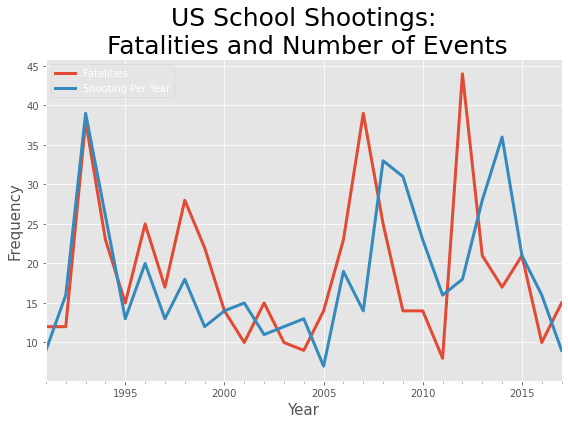

In [461]:
laws_and_shootings['Fatalities'].plot(figsize = (8, 6), linewidth = 3)
laws_and_shootings['Shooting Per Year'].plot(figsize = (8, 6), linewidth = 3)

plt.title('US School Shootings:\n Fatalities and Number of Events', fontsize = 25, color = 'k')
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.legend()
plt.tight_layout()

plt.savefig('US School Shootings: Fatalities and Number of Events', dpi = 200)

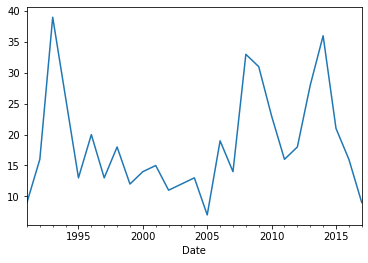

In [160]:
laws_and_shootings['Shooting Per Year'].plot();

## Time Series Work

[Prophet Documentation](resourcehttps://facebook.github.io/prophet/docs/quick_start.html#python-api)

When installing Prophet I had to install pystan first. It only worked with this specific verion.
!pip install pystan==2.17.1.0 and fbprophet

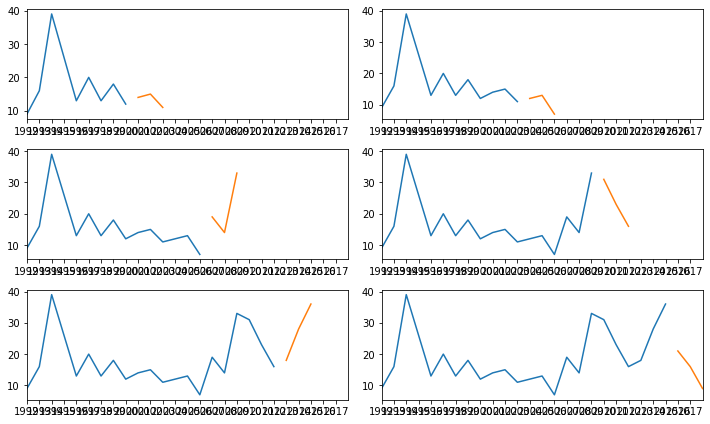

In [161]:
#This cell of code is from the lecture on time series

ts_split = TimeSeriesSplit(6)

fig,ax = plt.subplots(3, 2, figsize = (10,6))
years = mdates.YearLocator()
years_graph = mdates.DateFormatter('%Y')


for idx, (train_idx, test_idx) in enumerate(ts_split.split(laws_and_shootings)):
    ax[idx//2,idx%2].plot(laws_and_shootings.iloc[train_idx]['Shooting Per Year'])
    ax[idx//2,idx%2].plot(laws_and_shootings.iloc[test_idx]['Shooting Per Year'])
    ax[idx//2,idx%2].xaxis.set_major_locator(years)
    ax[idx//2,idx%2].xaxis.set_major_formatter(years_graph)
    ax[idx//2,idx%2].set_xlim(laws_and_shootings.index.min(), laws_and_shootings.index.max())

#plt.xticks(range(len(laws_and_shootings.index)),list(laws_and_shootings.index))
#plt.xlabel('Years', fontsize = 12)
#plt.ylabel('Count', fontsize = 12)
plt.tight_layout();

In [162]:
laws_and_shootings.head()

,Fatalities,Wounded,Shooting Per Year,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
Date,,,,,,,,,,,,,,,,,,,,,
1991-12-31,12,1.0,9,3,14,3,10,0,0,0,...,2,2,5,9,3,3,10,4,11,863
1992-12-31,12,29.0,16,3,15,3,10,0,0,0,...,2,2,5,9,3,3,10,4,11,896
1993-12-31,38,5.0,39,4,15,3,10,0,0,0,...,2,2,5,9,3,3,10,4,11,923
1994-12-31,23,8.0,26,8,16,5,10,0,1,1,...,2,3,5,11,3,3,11,4,11,1021
1995-12-31,15,4.0,13,9,16,5,10,0,1,1,...,2,3,5,12,3,3,12,4,11,1035


In [163]:
#Established new dataframes, 
#one for number of shootings and the year, the second for number of gun laws total and the year.

yearandshootings = pd.DataFrame()

yearandlaws = pd.DataFrame()

In [164]:
#Created a list the of columns of interest

count = list(laws_and_shootings['Shooting Per Year'])
lawcount = list(laws_and_shootings['lawtotal'])

In [165]:
#Filled in each dataset

yearandshootings['ds'] = pd.to_datetime(laws_and_shootings.index, format = "%Y")
yearandshootings['y'] = count

yearandlaws['ds'] = pd.to_datetime(laws_and_shootings.index, format = "%Y")
yearandlaws['y'] = lawcount

yearandshootings.head(), yearandlaws.head()

(          ds   y
 0 1991-12-31   9
 1 1992-12-31  16
 2 1993-12-31  39
 3 1994-12-31  26
 4 1995-12-31  13,
           ds     y
 0 1991-12-31   863
 1 1992-12-31   896
 2 1993-12-31   923
 3 1994-12-31  1021
 4 1995-12-31  1035)

In [166]:
model = Prophet()
model.fit(yearandshootings)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [167]:
lawmodel = Prophet()
lawmodel.fit(yearandlaws)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [168]:
future = model.make_future_dataframe(periods=5, freq = 'Y')
future.tail()

,ds
27,2018-12-31
28,2019-12-31
29,2020-12-31
30,2021-12-31
31,2022-12-31


In [169]:
lawfuture = lawmodel.make_future_dataframe(periods=5, freq = 'Y')
lawfuture.tail()

,ds
27,2018-12-31
28,2019-12-31
29,2020-12-31
30,2021-12-31
31,2022-12-31


In [170]:
forecast = model.predict(future)

lawforecast = lawmodel.predict(lawfuture)
#forecast

In [171]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2018-12-31,20.218767,10.347456,30.919134
28,2019-12-31,18.881639,9.122306,29.552716
29,2020-12-31,22.672708,12.348910,33.254908
30,2021-12-31,21.881739,11.315006,33.127244
31,2022-12-31,20.816959,10.349427,30.717231


In [172]:
lawforecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2018-12-31,1396.557750,1380.013998,1412.705856
28,2019-12-31,1413.916450,1396.120928,1431.249518
29,2020-12-31,1427.498878,1408.071283,1447.316034
30,2021-12-31,1454.680372,1432.884957,1476.236896
31,2022-12-31,1476.970167,1450.378824,1502.734254


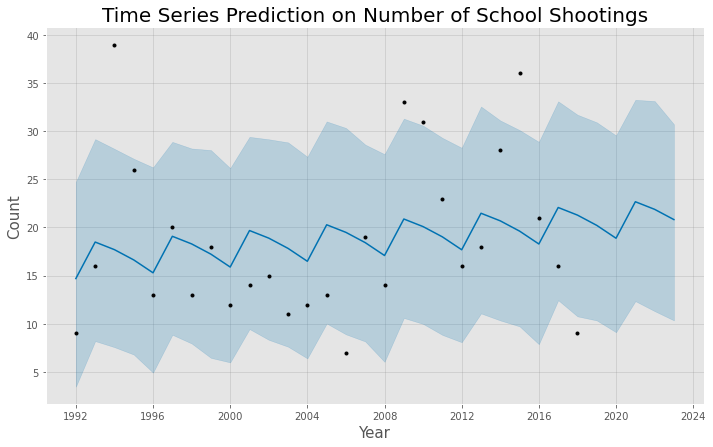

In [333]:
fig1 = model.plot(forecast)
plt.title('Time Series Prediction on Number of School Shootings', fontsize = 20 ,color = 'k')
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Year', fontsize = 15)

plt.savefig('Time Series Prediction on Number of School Shootings')
plt.show()

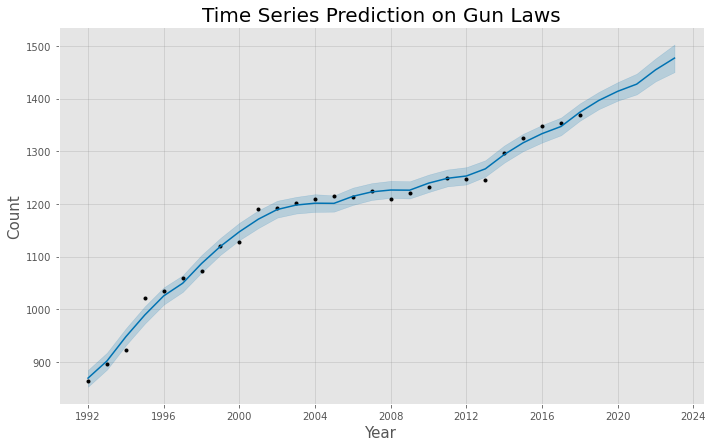

In [334]:
fig2 = lawmodel.plot(lawforecast)
plt.title('Time Series Prediction on Gun Laws', fontsize = 20 ,color = 'k')
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Year', fontsize = 15)

plt.savefig('Time Series Prediction on Gun Laws')

Text(0.5, 33.0, 'Year')

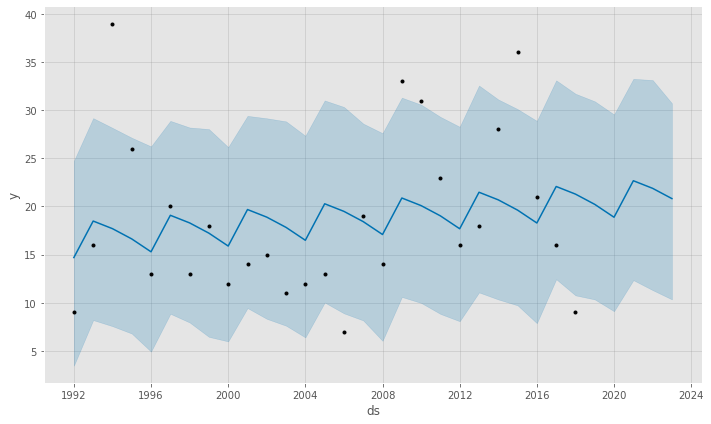

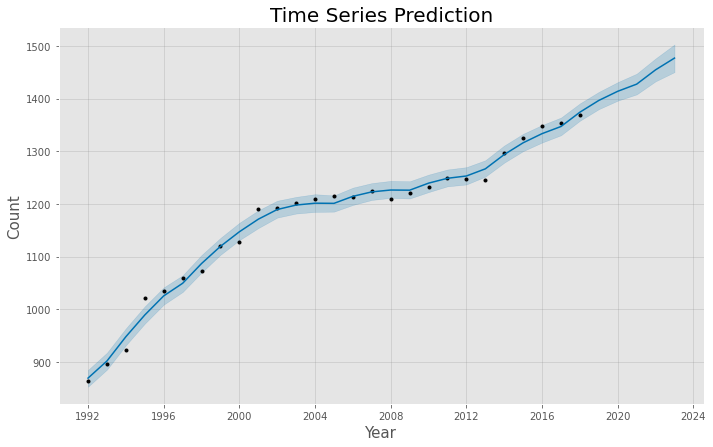

In [394]:
model.plot(forecast)
lawmodel.plot(lawforecast)
plt.title('Time Series Prediction', fontsize = 20 ,color = 'k')
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Year', fontsize = 15)

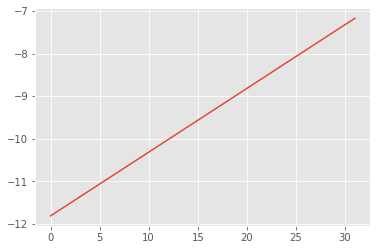

In [318]:
forecast['trend'].plot();

## Return to Mapping

In [299]:
lat = []
lon = []        

In [300]:
place = updated_shooting['City'] + ' ' + updated_shooting['State']
place = list(place)

In [301]:
#place

In [302]:
updated_shooting.shape

(557, 10)

This cell below will take some time to run. This is a good time for a 10 minute break :)

In [303]:
geolocator = Nominatim(user_agent = 'tor_explorer')

for elem in place:
    loc = geolocator.geocode(elem)
        #print(loc.raw['lat'], loc.raw['lon'])
    try:
        lat.append(loc.latitude)
        lon.append(loc.longitude)
            
    except:
        print(elem)
        
#Realized this was not working because four of the cities are mispelled. 
#They should be Carrollton, Grundy, Noblesville, Bloutsville.



In [ ]:
#print(lat, lon)

In [304]:
len(lat), len(lon)

(557, 557)

In [305]:
updated_shooting['Latitude'] = lat
updated_shooting['Longitude'] = lon

In [306]:
updated_shooting.head()

,City,State,AreaType,School,Fatalities,Wounded,Source,Desc,Latitude,Longitude
Date,,,,,,,,,,
1990-03-27,Brooklyn,New York,NaN,C,0,1.0,Wikp,A black youth was taunted with racial slurs by...,40.650104,-73.949582
1990-05-20,Centerville,Tennessee,suburban,HS,1,NaN,Pah,NaN,35.778956,-87.466959
1990-08-26,Las Vegas,Nevada,urban,HS,1,NaN,Pah,NaN,4.584712,-74.099235
1990-09-11,San Antonio,Texas,NaN,HS,0,3.0,Wikp,3 students were wounded when gunfire broke out...,18.174167,-96.129722
1991-01-08,Richardson,Texas,urban,HS,0,NaN,Pah,NaN,32.948179,-96.729721


In [307]:
locat = geoloc.geocode('Brooklyn New York')
print(locat.latitude, locat.longitude)

40.6501038 -73.9495823


I was able to generate a map with the location of eah shooting. 
Still working on getting a legend to distinguish the color meanings for each marker.

Ideally I would like to create a heat map by state.

In [319]:
fig = go.Figure(data=go.Scattergeo(
        lon = updated_shooting['Longitude'],
        lat = updated_shooting['Latitude'],
        text = updated_shooting['City'],
        mode = 'markers',
        marker_color = updated_shooting['Fatalities']+ updated_shooting['Wounded'],
        opacity = 0.5,
        showlegend = True))

fig.update_layout(title = 'US School Shootings by City',
        geo_scope='usa')

plt.savefig('US School Shootings by City')
fig.show()

<Figure size 432x288 with 0 Axes>

In [360]:
state_guns['# of guns per capita'].max()

229.24

In [362]:
state_lst = list(state_guns['State'])
abbreviations = []

In [363]:
state_lst[1]

'Washington D.C.'

In [364]:
state_lst[1] = 'District of Columbia'
state_lst[1]

'District of Columbia'

In [365]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [366]:
for elem in state_lst:
    for key, val in us_state_abbrev.items():
        if elem == key:
            abbreviations.append(val)

In [367]:
len(abbreviations)

51

In [368]:
state_guns.insert(loc = 1, column = 'State_Abreviation',value = abbreviations)

In [369]:
state_guns.head()

,Rank,State_Abreviation,State,# of guns per capita,# of guns registered
0,1,WY,Wyoming,229.24,"132,806"
1,2,DC,Washington D.C.,68.05,"47,228"
2,3,NH,New Hampshire,46.76,"64,135"
3,4,NM,New Mexico,46.73,"97,580"
4,5,VA,Virginia,36.34,"307,822"


In [370]:
st_abrev = state_guns['State_Abreviation'].tolist()

Working on creating a heat map of the Guns per State. Need to work on the legen and color coding of the states. I don't want colors repeated since it looks confusing as is.

In [451]:
no_outlier_state_guns = state_guns

In [454]:
no_outlier_state_guns = no_outlier_state_guns.replace({229.24 : 0})

In [456]:
fig = px.choropleth(data_frame = no_outlier_state_guns, locations = st_abrev, locationmode = 'USA-states', 
                    color = '# of guns per capita', scope = 'usa', title = 'Number of Guns Per Capita', hover_name = 'State_Abreviation')
fig.show()

# Regression Model

In [291]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import datetime


In [359]:
final_merged_year_state.head()

year  age18longgunpossess  age18longgunsale  \
Date       State                                                       
1991-01-01 Alabama     1991.0                  0.0               0.0   
           Alaska      1991.0                  0.0               0.0   
           Arizona     1991.0                  0.0               0.0   
           Arkansas    1991.0                  0.0               0.0   
           California  1991.0                  0.0               1.0   

                       age21handgunpossess  age21handgunsale  \
Date       State                                               
1991-01-01 Alabama                     0.0               0.0   
           Alaska                      0.0               0.0   
           Arizona                     0.0               0.0   
           Arkansas                    0.0               0.0   
           California                  0.0               1.0   

                       age21longgunpossess  age21longgunsale  \
Date       State                                               
1991-01-01 Alabama                     0.0               0.0   
           Alaska                      0.0               0.0   
           Arizona                     0.0               0.0   
           Arkansas                    0.0               0.0   
           California                  0.0               0.0   

                       age21longgunsaled  alcoholism  alctreatment  ...  \
Date       State                                                    ...   
1991-01-01 Alabama                   0.0         1.0           0.0  ...   
           Alaska                    0.0         0.0           0.0  ...   
           Arizona                   0.0         0.0           0.0  ...   
           Arkansas                  0.0         0.0           0.0  ...   
           California                0.0         1.0           0.0  ...   

                       universalpermith  violent  violenth  violentpartial  \
Date       State                                                             
1991-01-01 Alabama                  0.0      0.0       0.0             0.0   
           Alaska                   0.0      0.0       0.0             0.0   
           Arizona                  0.0      0.0       0.0             0.0   
           Arkansas                 0.0      0.0       0.0             0.0   
           California               1.0      1.0       1.0             1.0   

                       waiting  waitingh  lawtotal  Fatalities  Wounded  \
Date       State                                                          
1991-01-01 Alabama         0.0       1.0      15.0         0.0      0.0   
           Alaska          0.0       0.0      10.0         0.0      0.0   
           Arizona         0.0       0.0      12.0         0.0      0.0   
           Arkansas        0.0       0.0      15.0         0.0      0.0   
           California      1.0       1.0      58.0         1.0      0.0   

                       Number of Shootings  
Date       State                            
1991-01-01 Alabama                     0.0  
           Alaska                      0.0  
           Arizona                     0.0  
           Arkansas                    0.0  
           California                  1.0  

[5 rows x 138 columns]

In [253]:
final_merged_year_state.columns.get_loc('lawtotal')

134

#### How does the number of gun laws predict the number of shootings?

In [422]:
final_merged_year_state.head()

year  age18longgunpossess  age18longgunsale  \
Date       State                                                       
1991-01-01 Alabama     1991.0                  0.0               0.0   
           Alaska      1991.0                  0.0               0.0   
           Arizona     1991.0                  0.0               0.0   
           Arkansas    1991.0                  0.0               0.0   
           California  1991.0                  0.0               1.0   

                       age21handgunpossess  age21handgunsale  \
Date       State                                               
1991-01-01 Alabama                     0.0               0.0   
           Alaska                      0.0               0.0   
           Arizona                     0.0               0.0   
           Arkansas                    0.0               0.0   
           California                  0.0               1.0   

                       age21longgunpossess  age21longgunsale  \
Date       State                                               
1991-01-01 Alabama                     0.0               0.0   
           Alaska                      0.0               0.0   
           Arizona                     0.0               0.0   
           Arkansas                    0.0               0.0   
           California                  0.0               0.0   

                       age21longgunsaled  alcoholism  alctreatment  ...  \
Date       State                                                    ...   
1991-01-01 Alabama                   0.0         1.0           0.0  ...   
           Alaska                    0.0         0.0           0.0  ...   
           Arizona                   0.0         0.0           0.0  ...   
           Arkansas                  0.0         0.0           0.0  ...   
           California                0.0         1.0           0.0  ...   

                       universalpermith  violent  violenth  violentpartial  \
Date       State                                                             
1991-01-01 Alabama                  0.0      0.0       0.0             0.0   
           Alaska                   0.0      0.0       0.0             0.0   
           Arizona                  0.0      0.0       0.0             0.0   
           Arkansas                 0.0      0.0       0.0             0.0   
           California               1.0      1.0       1.0             1.0   

                       waiting  waitingh  lawtotal  Fatalities  Wounded  \
Date       State                                                          
1991-01-01 Alabama         0.0       1.0      15.0         0.0      0.0   
           Alaska          0.0       0.0      10.0         0.0      0.0   
           Arizona         0.0       0.0      12.0         0.0      0.0   
           Arkansas        0.0       0.0      15.0         0.0      0.0   
           California      1.0       1.0      58.0         1.0      0.0   

                       Number of Shootings  
Date       State                            
1991-01-01 Alabama                     0.0  
           Alaska                      0.0  
           Arizona                     0.0  
           Arkansas                    0.0  
           California                  1.0  

[5 rows x 138 columns]

In [246]:
X = final_merged_year_state.iloc[:, : -1]
y = final_merged_year_state['Number of Shootings']

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [250]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
mean_squared_error(y_test, y_pred)

0.21754037037037038

In [294]:
r2_score(y_test, y_pred)

0.6697756746626686

In [261]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_y_pred = lin_model.predict(X_test)
mean_squared_error(y_test, lin_y_pred)

0.8099737370729214

In [396]:
r2_score(y_test, lin_y_pred)

-0.2295328467561213

In [395]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)
mean_squared_error(y_test, gb_y_pred)

0.1878462835907404

In [397]:
r2_score(y_test, gb_y_pred)

0.7148510312809225

In [381]:
coeffs = lin_model.coef_
print(f'Coefficients are {coeffs}')
print(f'Sorted coefficients are {np.argsort(coeffs)}')

Coefficients are [ 2.25127626e-03 -1.74302328e-01  1.62486165e-01 -3.02308253e-02
  2.29515299e-01  1.80197069e+00  3.31714987e-01  3.31714987e-01
 -1.48726516e-02 -5.43275964e-02 -2.18495743e-01 -3.24464181e-01
  1.13207742e-01  9.68805228e-01  1.13207742e-01 -2.05633665e-01
  1.15579043e-01  1.34467103e+00  1.34467103e+00  8.92544523e-02
 -2.17827374e+00 -3.38303218e-01  1.28544946e-02  3.00925512e-01
 -7.36399776e-01 -3.26596823e-01  5.76289804e-01 -1.46950391e-01
  1.28544946e-02  7.82500004e-02  6.92857371e-02  5.77205860e-02
 -2.71483468e-02 -2.59426700e-01  1.90496199e-01 -6.93149527e-02
  7.32851978e-01 -9.83619668e-02  1.20177260e+00 -7.62417092e-01
  1.85367618e-01 -8.22206108e-02 -7.44995367e-03 -3.86436690e-01
 -1.60976011e+00 -1.60604418e-01  1.48029850e+00 -1.76903875e-02
  6.35371059e-02  5.07270951e-02  4.99030037e-01  4.86220026e-01
 -7.29559652e-01 -6.43890393e-02 -1.46240967e-01  6.32853991e-01
 -1.36574866e+00 -2.68061076e-01 -2.32286787e-01  2.17760298e-03
 -1.2682

In [385]:
for i in np.argsort(coeffs):
    print(X.columns[i])

inspection
reportall
assaulttransfer
magazinepreowned
mcdvsurrendernoconditions
tenroundlimit
dvrosurrender
gunshowh
universalpermit
preemptionbroad
liability
defactoregh
registrationh
cap18
expartesurrendernoconditions
junkgun
permit
lockp
showing
traffickingprohibitedh
opencarryl
reportdealerh
microstamp
universalh
dvroremoval
magazine
permith
strawpurchaseh
backgroundpurge
capaccess
amm21h
violentpartial
loststolen
reportallh
mcdvremovalallowed
gvro
residential
college
gvrolawenforcement
amm18
ammrecords
recordsall
age18longgunpossess
dvrosurrenderdating
nosyg
capunloaded
fingerprint
incidentremoval
incidentall
dealerh
dvro
danger
felony
alctreatment
universalpermith
mcdvdating
age21handgunpossess
ccrevoke
elementary
alcoholism
dvrodating
immunity
year
mcdv
lawtotal
opencarrypermitl
capuses
cap14
preemption
invcommitment
expartedating
ccrenewbackground
exparte
ccbackgroundnics
permitconcealed
ccbackground
mentalhealth
assaultregister
stalking
recordsdealerh
invoutpatient
ammbackgrou

In [384]:
feats = rf_model.feature_importances_
    
print(f'Feature importances are {feats}')
print(f'Sorted feature importances are {np.argsort(feats)[::-1]}')

Feature importances are [2.10764674e-03 2.42290333e-04 3.23021739e-04 3.30053790e-02
 6.08503024e-03 0.00000000e+00 2.86027420e-05 1.93083489e-07
 1.16218730e-04 1.44250998e-04 1.50574353e-03 3.11003938e-04
 1.49392986e-05 2.34979002e-04 3.16688300e-05 1.22967876e-07
 4.53324070e-04 1.76354643e-02 2.31464355e-02 2.68161174e-05
 2.37105730e-05 8.97031234e-05 3.43228350e-03 1.21545842e-03
 1.39681295e-04 3.91409283e-04 3.36517857e-04 1.45414249e-04
 2.93615786e-03 4.72534370e-03 2.90098016e-04 2.59393031e-03
 6.47887025e-04 6.54257792e-04 7.84624866e-04 1.26060801e-03
 3.55914031e-04 1.82672979e-03 1.49260317e-04 1.19960734e-03
 9.63427593e-02 1.13983019e-02 1.38077286e-03 5.92457620e-04
 1.44690251e-03 2.76050232e-04 1.41091186e-03 2.71461707e-04
 1.54083947e-03 2.81553332e-04 2.41328178e-04 1.10842423e-03
 3.70741801e-04 1.61595353e-03 7.96195791e-04 3.40518904e-05
 1.65527762e-04 1.21199182e-05 2.48692535e-05 6.14331797e-04
 5.91523107e-06 1.67766513e-04 1.34639682e-06 2.02094258e-03


In [ ]:
for i in np.argsort(coeffs):
    print(X.columns[i])

In [386]:
for i in np.argsort(feats):
    print(X.columns[i])

age21longgunpossess
ammrecords
age21longgunsaled
locked
inspection
incidentall
residential
universal
gvro
registration
ammbackground
mcdvremovalrequired
assaulttransfer
gvrolawenforcement
assaultregister
age21longgunsale
ammpermit
gunshow
personalized
microstamp
loststolen
statechecks
magazinepreowned
reportdealer
registrationh
liability
onepermonth
backgroundpurge
Fatalities
Wounded
alcoholism
opencarryl
cap18
lockstandards
lawtotal
alctreatment
capunloaded
magazine
defactoreg
mentalhealth
recordsallh
gunshowh
violent
incidentremoval
recordsall
waiting
showing
preemption
recordsdealer
ammlicense
expartesurrender
age18longgunpossess
invoutpatient
elementary
dvrosurrenderdating
lockd
expartedating
ccbackgroundnics
recordsdealerh
reportallh
amm21h
age18longgunsale
capliability
permitconcealed
dealer
lockp
traffickingprohibitedh
expartesurrendernoconditions
capaccess
universalpermith
nosyg
stalking
onefeature
ammrestrict
traffickingprohibited
mcdvremovalallowed
dvroremoval
immunity
ccrevo

In [399]:
gbfeats = gb_model.feature_importances_
    
print(f'Feature importances are {gbfeats}')
print(f'Sorted feature importances are {np.argsort(gbfeats)[::-1]}')

Feature importances are [2.46133098e-02 0.00000000e+00 9.54545883e-05 1.84329705e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.00870822e-04 2.34915701e-05 0.00000000e+00 3.63424516e-05
 0.00000000e+00 8.69343011e-05 5.18969962e-07 4.20183540e-07
 4.38891634e-04 0.00000000e+00 6.47810037e-06 5.63232860e-03
 1.83537628e-05 0.00000000e+00 0.00000000e+00 2.45840043e-07
 1.73318014e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.97164886e-04 6.89626520e-06 1.37657382e-03
 4.98454189e-04 8.00226602e-04 2.39013925e-04 9.02473214e-04
 6.35265986e-05 1.86157912e-04 0.00000000e+00 3.69749071e-03
 5.77917443e-05 3.99274641e-06 9.06665456e-05 3.25446606e-04
 0.00000000e+00 9.40708212e-06 1.37442938e-04 1.92456005e-03
 0.00000000e+00 4.25998161e-04 7.39470613e-05 1.44027612e-04
 0.00000000e+00 1.34172276e-03 1.27869667e-03 6.70143543e-07
 4.03061447e-05 8.64403199e-06 1.62885942e-04 8.23652661e-03
 0.00000000e+00 4.66111304e-05 0.00000000e+00 2.04609446e-04


In [400]:
for i in np.argsort(gbfeats):
    print(X.columns[i])

locked
capuses
recordsall
preemptionnarrow
preemptionbroad
preemption
personalized
opencarrypermitl
opencarryl
mcdvsurrendernoconditions
mcdvsurrenderdating
defactoreg
mcdvsurrender
mcdvremovalrequired
mcdvremovalallowed
mcdvdating
magazinepreowned
dvrosurrender
magazine
lockstandards
lockp
exparte
lockd
inspection
capunloaded
incidentall
capliability
recordsallh
age18longgunpossess
violent
universalpermith
age21handgunsale
age21longgunpossess
age21longgunsale
age21longgunsaled
universalpermit
universalh
amm18
universal
ammbackground
traffickingprohibitedh
theft
tenroundlimit
statechecksh
assault
residential
registrationh
registration
backgroundpurge
cap14
recordsdealer
capaccess
expartesurrendernoconditions
waiting
permith
cap16
ammrecords
ammpermit
gunshow
junkgun
waitingh
dvro
reportallh
assaultlist
ccbackgroundnics
gvro
dvrosurrenderdating
statechecks
assaulttransfer
alctreatment
amm21h
gunshowh
incidentremoval
strawpurchase
mentalhealth
drugmisdemeanor
liability
dealer
reportdeale

In [263]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_y_pred = log_model.predict(X_test)
mean_squared_error(y_test, log_y_pred)

/Users/laurenmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7296296296296296

#### How do school shootings predict the number of gun laws?

In [256]:
X2 = final_merged_year_state.drop(columns = 'lawtotal', axis = 1)
y2 = final_merged_year_state['lawtotal']

In [257]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [387]:
rf2_model = RandomForestRegressor()
rf2_model.fit(X_train2,y_train2)
y_pred2 = rf2_model.predict(X_test2)
mean_squared_error(y_test2, y_pred2)

0.5212440740740741

In [403]:
r2_score(y_test2, y_pred2)

0.9990558002249061

In [264]:
lin2_model = LinearRegression()
lin2_model.fit(X_train2,y_train2)
lin2_y_pred = lin2_model.predict(X_test2)
mean_squared_error(y_test2, lin2_y_pred)

3.820779455709922e-25

In [402]:
r2_score(y_test2, lin2_y_pred)

1.0

In [404]:
gb2_model = GradientBoostingRegressor()
gb2_model.fit(X_train2,y_train2)
gb2_y_pred = gb2_model.predict(X_test2)
mean_squared_error(y_test2, gb2_y_pred)

1.0164853813819574

In [405]:
r2_score(y_test2, gb2_y_pred)

0.9981587027724164

In [389]:
coeffs2 = lin2_model.coef_
print(f'Coefficients are {coeffs2}')
print(f'Sorted coefficients are {np.argsort(coeffs2)}')

Coefficients are [7.75708142e-14 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.0000

In [390]:
for i in np.argsort(coeffs2):
    print(X.columns[i])

Wounded
lawtotal
Fatalities
year
assaultlist
age18longgunsale
preemptionbroad
lockstandards
capuses
defactoregh
nosyg
immunity
ammpermit
assault
amm18
expartesurrendernoconditions
mayissue
showing
onefeature
preemption
gvrolawenforcement
opencarrypermitl
statechecks
waiting
universalh
collegeconcealed
permitconcealed
mcdvremovalrequired
dealerh
assaulttransfer
lockp
junkgun
universalpermith
theft
ammrecords
opencarrypermith
microstamp
training
alcoholism
traffickingprohibited
mcdvremovalallowed
cap18
defactoreg
violentpartial
expartesurrenderdating
ammlicense
exparte
fingerprint
age21longgunsaled
mcdvdating
reportdealer
ccrevoke
opencarryh
onepermonth
mcdvsurrendernoconditions
dvrosurrenderdating
capunloaded
mcdvsurrender
ccbackground
expartesurrender
universal
violent
purge
age21longgunsale
recordsdealerh
danger
stalking
liability
loststolen
traffickingbackground
dvrosurrender
security
ammbackground
opencarryl
strawpurchase
alctreatment
permith
registrationh
magazine
reportdealerh
fel

In [391]:
feats2 = rf2_model.feature_importances_
    
print(f'Feature importances are {feats2}')
print(f'Sorted feature importances are {np.argsort(feats2)[::-1]}')

Feature importances are [2.63493244e-03 2.15622803e-04 3.24487373e-04 3.11107071e-02
 6.23723491e-03 8.43598918e-08 0.00000000e+00 3.97709644e-05
 1.61205812e-04 1.29972265e-04 2.11424100e-03 2.84201135e-04
 3.39701353e-04 2.23976702e-04 1.19682961e-04 9.65697517e-08
 5.34622625e-04 1.15061655e-02 2.39512969e-02 2.40624762e-05
 2.71441356e-05 4.46069617e-04 3.01123303e-03 1.66263682e-03
 6.10385851e-04 3.49530737e-04 5.43424998e-04 2.57385191e-05
 2.74690917e-03 4.34654576e-03 2.61034414e-04 2.66314212e-03
 4.99543461e-04 5.98024747e-04 7.04378311e-04 1.28787284e-03
 1.26529212e-04 1.26248437e-03 1.26463933e-04 7.02970281e-04
 9.40834342e-02 1.12441526e-02 1.53846175e-03 4.32106922e-04
 1.79347553e-03 3.18688624e-04 1.06897175e-03 4.02636542e-04
 1.35898915e-03 1.28254230e-03 3.67263842e-04 2.51763560e-03
 1.06656040e-03 1.36873429e-03 8.34072790e-04 2.17130498e-05
 4.89011855e-05 2.72789922e-05 2.96265446e-05 5.30643844e-04
 4.66322009e-06 3.70076469e-04 5.80219867e-07 1.45221534e-03


In [392]:
for i in np.argsort(feats2):
    print(X.columns[i])

age21longgunsale
locked
age21longgunpossess
ammrecords
registration
inspection
residential
incidentall
mcdvremovalrequired
magazine
universal
gunshow
assaultregister
capunloaded
assaulttransfer
gvro
microstamp
gvrolawenforcement
liability
waiting
onepermonth
age21longgunsaled
magazinepreowned
statechecks
loststolen
gunshowh
personalized
mentalhealth
reportall
lawtotal
registrationh
recordsallh
reportdealer
recordsall
universalpermith
lockstandards
ammpermit
reportallh
Wounded
Fatalities
defactoreg
dealer
alctreatment
violent
alcoholism
preemption
opencarryl
age18longgunpossess
ammlicense
recordsdealer
showing
ccbackgroundnics
purge
onefeature
amm21h
mcdvsurrender
dvrosurrenderdating
lockd
age18longgunsale
ammbackground
recordsdealerh
permitconcealed
capaccess
threedaylimit
nosyg
expartesurrender
incidentremoval
elementary
traffickingprohibitedh
dvroremoval
invoutpatient
backgroundpurge
strawpurchaseh
ccrevoke
traffickingprohibited
immunity
ammrestrict
capliability
stalking
college
open

In [406]:
gbfeats2 = gb2_model.feature_importances_
    
print(f'Feature importances are {gbfeats2}')
print(f'Sorted feature importances are {np.argsort(gbfeats2)[::-1]}')

Feature importances are [6.99219329e-04 2.48281581e-05 1.07320912e-03 2.65893337e-02
 1.08088165e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.82910805e-04 2.37954329e-05 5.31173030e-03 4.18522767e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.26132529e-03 1.36142252e-03 3.34223745e-02 4.15985802e-06
 6.96378137e-06 2.10450359e-03 0.00000000e+00 3.32373148e-03
 1.80808199e-03 1.76584187e-05 4.51134434e-04 0.00000000e+00
 1.06685432e-02 8.34601144e-04 1.62141302e-04 1.52393055e-03
 5.51968705e-04 9.98619299e-04 9.06771407e-05 3.43142974e-04
 7.57828735e-06 1.49305301e-04 0.00000000e+00 4.97059790e-06
 9.01955517e-02 5.32788957e-03 8.31355771e-03 9.29146170e-04
 8.20389722e-04 4.49524131e-05 5.31033035e-03 7.87914748e-04
 2.37738709e-03 7.11715715e-03 0.00000000e+00 1.40168835e-03
 1.00813300e-02 5.72999311e-04 2.36904394e-04 0.00000000e+00
 1.82972615e-05 0.00000000e+00 1.72040511e-05 1.05393851e-03
 0.00000000e+00 1.20416269e-04 0.00000000e+00 5.65216395e-03


In [407]:
for i in np.argsort(gbfeats2):
    print(X.columns[i])

locked
expartesurrender
gunshow
gvro
incidentall
inspection
liability
lockp
lockstandards
magazinepreowned
mentalhealth
onefeature
permit
personalized
registration
registrationh
residential
strawpurchase
threedaylimit
training
violent
waiting
defactoreg
capunloaded
Wounded
ammbackground
ammlicense
age21longgunsale
ammpermit
ammrecords
age21longgunpossess
age21longgunsaled
cap14
assaultregister
defactoregh
reportallh
assaulttransfer
mcdvremovalallowed
dealer
recordsall
mcdvsurrendernoconditions
mcdvremovalrequired
purge
microstamp
magazine
invoutpatient
showing
Fatalities
statechecks
loststolen
gvrolawenforcement
capaccess
strawpurchaseh
gunshowh
onepermonth
alctreatment
age18longgunpossess
universalh
lawtotal
recordsallh
recordsdealer
amm21h
dvrosurrenderdating
universal
collegeconcealed
nosyg
incidentremoval
dealerh
ccbackgroundnics
alcoholism
fingerprint
stalking
traffickingprohibited
danger
preemption
capliability
theft
ccrevoke
felony
lockd
year
opencarryl
elementary
dvrosurrender


Realizing this data may be biased since the individual gun laws as still accounted for in the `X_train` and `X_test`

### Pearson and Spearman Correlation Tests

In [438]:
final_merged_year_state = final_merged_year_state.rename(columns={'Number of Shootings': 'NumberOfShootings'})

In [442]:
final_merged_year_state.head()

year  age18longgunpossess  age18longgunsale  \
Date       State                                                       
1991-01-01 Alabama     1991.0                  0.0               0.0   
           Alaska      1991.0                  0.0               0.0   
           Arizona     1991.0                  0.0               0.0   
           Arkansas    1991.0                  0.0               0.0   
           California  1991.0                  0.0               1.0   

                       age21handgunpossess  age21handgunsale  \
Date       State                                               
1991-01-01 Alabama                     0.0               0.0   
           Alaska                      0.0               0.0   
           Arizona                     0.0               0.0   
           Arkansas                    0.0               0.0   
           California                  0.0               1.0   

                       age21longgunpossess  age21longgunsale  \
Date       State                                               
1991-01-01 Alabama                     0.0               0.0   
           Alaska                      0.0               0.0   
           Arizona                     0.0               0.0   
           Arkansas                    0.0               0.0   
           California                  0.0               0.0   

                       age21longgunsaled  alcoholism  alctreatment  ...  \
Date       State                                                    ...   
1991-01-01 Alabama                   0.0         1.0           0.0  ...   
           Alaska                    0.0         0.0           0.0  ...   
           Arizona                   0.0         0.0           0.0  ...   
           Arkansas                  0.0         0.0           0.0  ...   
           California                0.0         1.0           0.0  ...   

                       universalpermith  violent  violenth  violentpartial  \
Date       State                                                             
1991-01-01 Alabama                  0.0      0.0       0.0             0.0   
           Alaska                   0.0      0.0       0.0             0.0   
           Arizona                  0.0      0.0       0.0             0.0   
           Arkansas                 0.0      0.0       0.0             0.0   
           California               1.0      1.0       1.0             1.0   

                       waiting  waitingh  lawtotal  Fatalities  Wounded  \
Date       State                                                          
1991-01-01 Alabama         0.0       1.0      15.0         0.0      0.0   
           Alaska          0.0       0.0      10.0         0.0      0.0   
           Arizona         0.0       0.0      12.0         0.0      0.0   
           Arkansas        0.0       0.0      15.0         0.0      0.0   
           California      1.0       1.0      58.0         1.0      0.0   

                       NumberOfShootings  
Date       State                          
1991-01-01 Alabama                   0.0  
           Alaska                    0.0  
           Arizona                   0.0  
           Arkansas                  0.0  
           California                1.0  

[5 rows x 138 columns]

In [439]:
#Pearson Correlation

final_merged_year_state.lawtotal.corr(final_merged_year_state.NumberOfShootings, method = 'pearson')

0.17426559978869355

In [440]:
final_merged_year_state.Fatalities.corr(final_merged_year_state.NumberOfShootings, method = 'pearson')

0.4411032437919193

In [441]:
final_merged_year_state.Fatalities.corr(final_merged_year_state.Wounded, method = 'pearson')

0.5969057897328983

In [445]:
stats.pearsonr(final_merged_year_state['lawtotal'], final_merged_year_state['NumberOfShootings'])

(0.1742655997886933, 1.1455225174644952e-10)

In [444]:
stats.spearmanr(final_merged_year_state['lawtotal'], final_merged_year_state['NumberOfShootings'])

SpearmanrResult(correlation=0.1978372559490942, pvalue=2.2191358879806652e-13)

## NLP and LDA

I wanted to look at the description column in the school shooting dataframe to see if there were any commonalities. I deally I wanted to get to running an LDA model, but may not have time for that.

In [336]:
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
#nltk.download('stopwords')
from collections import Counter
import re

In [337]:
updated_shooting['Desc'][0]

'A black youth was taunted with racial slurs by three white youths in the stairwell of a public school in the¬†Bensonhurst¬†area of¬†Brooklyn. The 14-year-old was then shot and slightly wounded, because he had acted as peacemaker when the same boys had clashed with another black teen the month before.[240]'

Did some cleaning to get rid of null values, only the events from the Wikipedia source included a description. I also removed some strange characters so that I could work with the data further.

In [375]:
descriptions_df = updated_shooting.iloc[:,7]
descriptions = descriptions_df[descriptions_df.notnull()]
descriptions_lst = list(descriptions)
descriptions_lst[:5]

['A black youth was taunted with racial slurs by three white youths in the stairwell of a public school in the¬†Bensonhurst¬†area of¬†Brooklyn. The 14-year-old was then shot and slightly wounded, because he had acted as peacemaker when the same boys had clashed with another black teen the month before.[240]',
 '3 students were wounded when gunfire broke out at¬†Sam Houston High School. The incident took place at 11:55¬†a.m. and was gang related. 17-year-old John Campbell was wounded in the right foot, 18-year-old Larry Johnson was wounded in the right thigh and calf, and a 16-year-old received a chest wound. 18-year-old Kenneth Wolford, and two other male students were arrested and charged.[241]',
 '15-year-old Raul Calvo shot himself dead while playing Russian roulette inside a biology classroom at¬†Donna High School.[242]',
 'A teenager aimed and fired a handgun at a security guard who had chased him and three friends off the grounds of Ralph J. Bunche Middle School. He instead kille

In [379]:
str_descriptions = ' '.join(descriptions_lst)
str_descriptions = str_descriptions.replace('¬†', ' ')
str_descriptions[:200]

'A black youth was taunted with racial slurs by three white youths in the stairwell of a public school in the Bensonhurst area of Brooklyn. The 14-year-old was then shot and slightly wounded, because h'

In [342]:
Counter(str_descriptions.split()).most_common()

[('a', 523),
 ('the', 506),
 ('and', 410),
 ('was', 399),
 ('in', 349),
 ('of', 254),
 ('at', 228),
 ('to', 206),
 ('High', 184),
 ('student', 157),
 ('shot', 156),
 ('with', 139),
 ('School', 128),
 ('were', 123),
 ('The', 111),
 ('A', 102),
 ('killed', 92),
 ('school', 89),
 ('his', 86),
 ('on', 82),
 ('by', 81),
 ('students', 71),
 ('wounded', 71),
 ('an', 71),
 ('he', 69),
 ('two', 69),
 ('He', 68),
 ('after', 65),
 ('15-year-old', 64),
 ('shooting', 56),
 ('for', 52),
 ('arrested', 49),
 ('three', 48),
 ('student,', 47),
 ('one', 47),
 ('School.', 46),
 ('School,', 46),
 ('had', 45),
 ('shooting:', 45),
 ('sentenced', 45),
 ('charged', 45),
 ('as', 44),
 ('into', 43),
 ('before', 42),
 ('14-year-old', 41),
 ('16-year-old', 41),
 ('from', 41),
 ('police', 41),
 ('years', 38),
 ('injured', 38),
 ('Middle', 37),
 ('17-year-old', 36),
 ('fired', 36),
 ('who', 36),
 ('during', 36),
 ('Two', 35),
 ('campus', 34),
 ('University', 33),
 ('died', 31),
 ('fatally', 31),
 ('18-year-old', 30)

In [343]:
#stopwords.words('english')

Below is a list of the most common words, with stopwords removed.

In [344]:
lower_desc = str_descriptions.lower()
no_punc_desc = re.findall('[A-Za-z0-9]+', lower_desc)
filtered_descriptions = [w for w in no_punc_desc if w not in stopwords.words('english')]
Counter(filtered_descriptions).most_common()

[('year', 400),
 ('old', 400),
 ('school', 374),
 ('student', 217),
 ('high', 196),
 ('shot', 161),
 ('shooting', 130),
 ('two', 108),
 ('students', 97),
 ('killed', 97),
 ('wounded', 75),
 ('one', 75),
 ('15', 71),
 ('university', 67),
 ('three', 59),
 ('injured', 58),
 ('arrested', 56),
 ('police', 54),
 ('16', 49),
 ('charged', 49),
 ('murder', 47),
 ('14', 45),
 ('sentenced', 45),
 ('campus', 43),
 ('years', 42),
 ('teacher', 42),
 ('middle', 39),
 ('prison', 39),
 ('17', 38),
 ('fired', 38),
 ('fire', 38),
 ('died', 35),
 ('18', 34),
 ('five', 33),
 ('later', 33),
 ('fatally', 33),
 ('life', 32),
 ('shooter', 31),
 ('gun', 31),
 ('college', 30),
 ('people', 30),
 ('handgun', 28),
 ('outside', 28),
 ('opened', 28),
 ('injuries', 28),
 ('attempted', 28),
 ('parking', 28),
 ('lot', 28),
 ('another', 27),
 ('suspect', 27),
 ('shots', 26),
 ('game', 26),
 ('male', 24),
 ('state', 24),
 ('basketball', 24),
 ('officer', 24),
 ('argument', 21),
 ('assault', 21),
 ('suicide', 21),
 ('head'